In [1]:
#run calculation of statistics for all indices in the web
import pandas as pd
import numpy as np
import datetime as dt
import sys
import myfunctions as myf
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [27]:
import requests
from requests.auth import HTTPBasicAuth
sys.path.append('G:/stoxx/STOXX/Product Development & Research/Python')
with open('creds.txt') as c: #creds.txt file contains: name.surname@stoxx.com,pass
    creds = c.read()
creds=creds.split(',')
auth = HTTPBasicAuth(creds[0],creds[1])

url = 'https://www.stoxx.com/documents/stoxxnet/Documents/Resources/Data_Vendor_Codes/vendor_codes.csv'
r = requests.get(url, auth=auth)
text = r.text
rows = text.split('\n')[1:]
data = [x.split(',')[:-1] for x in rows if x!='']
df = pd.DataFrame(data)[[6,10,3,4]]
df = df[(df[3]=='EUR') & (df[4]!='Gross Return')][[6,10,4]]
df.columns = ['idx','symbol','type']
df.head(5)

,idx,symbol,type
0,EURO STOXX,SXXE,Price
1,EURO STOXX,SXXT,Net Return
6,EURO STOXX Total Market,BKXE,Price
7,EURO STOXX Total Market,BKXT,Net Return
10,STOXX North America 600,SXA1E,Price


In [28]:
locat = 'G:/stoxx/STOXX/Product Development & Research/Team/Antonio/Python/'
dfres = pd.DataFrame()
print(len(df.idx.drop_duplicates()), 'unique indices')

time1=time.time()

for ix in df.idx.drop_duplicates()[:]:
    #get history
    idxpair = list(df[df.idx==ix].sort('type', ascending=False)['symbol'])
    if len(idxpair)==2:
        try:
            dfts = myf.get_web_h(idxpair, special=False).sort('Date').reset_index(drop=True)
        except:
            try:
                dfts = myf.get_web_h(idxpair, special=True).sort('Date').reset_index(drop=True)
            except:
                #print(ix)
                #for f in idxpair:
                #    print('http://www.stoxx.com/download/historical_data/h_'+f.lower()+'.txt')
                continue
        #calculate stats
        dfix = get_stats(dfts)
        dfix['name'] = ix
        dfres = pd.concat([dfres, dfix])

cols = dfres.columns.tolist()
dfres = dfres[cols[-1:] + cols[:-1]]
dfres.iloc[:,1:] = np.around(dfres.iloc[:,1:].astype(np.double), decimals=4)

print('finished at ', datetime.datetime.now().time().isoformat())
time2=time.time()
print('time elapsed:', (time2-time1)/60, 'minutes')

dfres.to_csv(locat + 'index_ranking_results.csv', sep=';', index=False)

#dfres  

1591 unique indices
finished at  10:42:07.503097
time elapsed: 49.51938085158666 minutes


In [35]:
dfres.to_csv(locat + 'index_ranking_results.csv', sep=';', index=False)

In [34]:
fld = 'return_1y'#'sharpeR_5y'

w=dfres.sort(fld, ascending=False)[['name',fld]].head(10)
l=dfres.sort(fld, ascending=False)[['name',fld]].tail(10)
pd.concat([w,l], keys=['winners','losers'])

name return_1y
winners SX5T5S                   EURO STOXX 50 Daily Short 5  718.6879
        TCSKR                    STOXX Slovakia Total Market     0.086
        SXW1MDR             STOXX Global Maximum Dividend 40    0.0801
        SXEMD4R             STOXX Europe Maximum Dividend 40    0.0761
        SXP1MDR       STOXX Asia/Pacific Maximum Dividend 40    0.0664
        ENDLRR       iSTOXX Europe Next Dividend Low Risk 50    0.0629
        EE170R      STOXX Eastern Europe 300 Basic Resources    0.0563
        EE650R   STOXX Eastern Europe 300 Telecommunications    0.0552
        SD1R            STOXX EU Enlarged Select Dividend 15    0.0539
        TCEER                     STOXX Estonia Total Market    0.0469
losers  TCKRR                 STOXX South Korea Total Market    0.0001
        SXPOSKT                  STOXX Optimised South Korea         0
        SX5TSN                     EURO STOXX 50 Daily Short   -0.0261
        SX5T2SN             EURO STOXX 50 Daily Double Short   -0.0544
        SX5T3S                   EURO STOXX 50 Daily Short 3   -0.0802
        SX5T8S                   EURO STOXX 50 Daily Short 8   -0.0872
        SX5T4S                   EURO STOXX 50 Daily Short 4   -0.1002
        SX5T7S                   EURO STOXX 50 Daily Short 7   -0.1023
        SX5TDL8               EURO STOXX 50 Daily Leverage 8  -46.8066
        SX5T6S                   EURO STOXX 50 Daily Short 6 -685.0654

In [22]:
def get_stats(df1):
    rfrate=True
    import requests
    from requests.auth import HTTPBasicAuth

    def no_weeknd(dt1):
        if dt1.weekday()==5:
            dt1=dt1-dt.timedelta(days=1)
        elif dt1.weekday()==6:
            dt1=dt1-dt.timedelta(days=2)
        return dt1

    if rfrate==True:
        ratecurr = 'EUR'
        with open('creds.txt') as c: #creds.txt file contains: name.surname@stoxx.com,pass
            creds = c.read()
        creds=creds.split(',')
        auth = HTTPBasicAuth(creds[0],creds[1])

        url = "http://www.stoxx.com/download/customised/dowjones/eonia_rate.txt"
        r = requests.get(url, auth=auth)

        text = r.text
        rows = text.split('\n')[1:]
        data = [(x[:10], float(x[11:len(x)-1])/100) for x in rows if x!='']

        dfrate = pd.DataFrame(data, columns=['Date', 'rate'])
        dfrate['Date']=pd.to_datetime(dfrate['Date'], format='%d.%m.%Y', dayfirst=True)

        df1 = pd.merge(df1, dfrate, how='left', on='Date')
    elif rfrate==False:
        ratecurr = ''

    df1.fillna(method='pad', inplace=True)
    dto=df1.iloc[len(df1)-1,0]
    df1.reset_index(inplace=True,drop=True)

    dtytd = dt.date(dto.year-1, 12, 31)
    dtytd = no_weeknd(df1[df1.Date>=dtytd].iloc[0,0])

    dt1m = myf.add_months(dto,-1)
    dt1m = no_weeknd(df1[df1.Date>=dt1m].iloc[0,0])

    dt10 = myf.add_months(dto,-12*10)
    dt10 = no_weeknd(df1[df1.Date>=dt10].iloc[0,0])

    dt5 = myf.add_months(dto,-12*5)
    dt5 = no_weeknd(df1[df1.Date>=dt5].iloc[0,0])

    dt3 = myf.add_months(dto,-12*3)
    dt3 = no_weeknd(df1[df1.Date>=dt3].iloc[0,0])

    dt1 = myf.add_months(dto,-12)
    dt1 = no_weeknd(df1[df1.Date>=dt1].iloc[0,0])

    dt0 = myf.add_months(dto,-0)
    dt0 = no_weeknd(df1[df1.Date>=dt0].iloc[0,0])

    dtlst=[dt10, dt5, dt3, dt1, dtytd, dt1m, dt0] #6 dates

    dfvals=pd.DataFrame()
    for fe in dtlst:
        dfvals=pd.concat([dfvals, pd.DataFrame(df1[df1.Date<=fe].sort('Date', ascending=False).reset_index(drop=True).iloc[0,:]).T], axis=0)
    dfvals.reset_index(inplace=True,drop=True)
    actret = np.array(dfvals.iloc[len(dfvals)-1,1:3])/np.array(dfvals.iloc[0:len(dfvals)-1,1:3])-1
    dfret=pd.DataFrame(actret)
    dfret.columns=df1.columns[1:3]

    #annualized returns
    for x in range(len(actret)):
        ctobs = len(df1[(df1.Date <= dtlst[6]) & (df1.Date > dtlst[x])])
        dfret.iloc[x,:]=dfret.iloc[x,:].map(lambda x: (x+1)**(250/ctobs)-1)
    list1 = np.array(dfret)

    #vola
    returns=np.array(df1.iloc[1:len(df1),2])/np.array(df1.iloc[0:len(df1)-1,2])-1 #only for the net return version
    dfr=pd.DataFrame(returns)
    dfr['Date']=list(df1.loc[1:,'Date'])
    vol=[]
    for y in range(len(dtlst)-1):
        vol.append(np.std(dfr[(dfr.Date <= dtlst[6]) & (dfr.Date > dtlst[y])].iloc[:,0], ddof=1)*np.sqrt(250))
    dfvola=pd.DataFrame(vol)
    list2=np.array(dfvola)

    #dys
    dfdys=pd.DataFrame(list1)
    dfdys.iloc[:,1]=dfdys.iloc[:,1]-dfdys.iloc[:,0]
    list3 = np.array(dfdys.iloc[:,1])

    #sharpe ratio
    shrp=[]
    for d in range(len(dtlst[1:])):
        dft = df1[(df1.Date <= dtlst[6]) & (df1.Date > dtlst[d])]
        returns = np.array(dft.iloc[1:len(dft),2:3])/np.array(dft.iloc[0:len(dft)-1,2:3])-1
        eonia = np.array(dft.iloc[0:len(dft)-1,3])
        timedelta = np.array([(dft.iloc[i+1,0]-dft.iloc[i,0]).days for i in range(len(dft)-1)])
        drate = eonia*timedelta/365
        excessreturn = returns.T[0]-drate #, returns.T[1]-drate
        shrp.append((np.mean(excessreturn)/np.std(excessreturn, ddof=1))*np.sqrt(250))
    dfshrp = pd.DataFrame(shrp)
    #dfshrp.columns=df1.columns[1:3]
    list4 = np.array(dfshrp)

    #max drawdown
    mxdd = []
    for d in range(len(dtlst[1:])):
        dft = df1[(df1.Date <= dtlst[6]) & (df1.Date > dtlst[d])]
        pk = np.zeros(len(dft)+1)
        dd = np.zeros(len(dft)+1)
        h = np.array(dft.iloc[:,2])
        pk[0] = h[0]
        for i in range(len(h)):
            pk[i+1] = h[i] if h[i] > pk[i] else pk[i]
            dd[i+1] = h[i] / pk[i+1] - 1 if h[i] < pk[i+1] else 0
        dd = dd[1:]
        mxdd.append(abs(dd.min()))
    list5 = np.array(mxdd)

    dfix = pd.concat([pd.DataFrame(list1.T[1]), 
           pd.DataFrame(list2),
           pd.DataFrame(list3),
           pd.DataFrame(list4),
           pd.DataFrame(list5)], axis=0)
    dfix.columns= [idxpair[1]]
    dfix = dfix.T
    dfix.columns = ['return_10y', 'return_5y', 'return_3y', 'return_1y', 'return_ytd', 'return_1m',
                     'vola_10y', 'vola_5y', 'vola_3y', 'vola_1y', 'vola_ytd', 'vola_1m',
                     'dy_10y', 'dy_5y', 'dy_3y', 'dy_1y', 'dy_ytd', 'dy_1m',
                     'sharpeR_10y', 'sharpeR_5y', 'sharpeR_3y', 'sharpeR_1y', 'sharpeR_ytd', 'sharpeR_1m',
                     'maxDD_10y', 'maxDD_5y', 'maxDD_3y', 'maxDD_1y', 'maxDD_ytd', 'maxDD_1m']
    return dfix


In [19]:
idxlist = idxpair
usedates=False
special=False
import requests
from requests.auth import HTTPBasicAuth
with open('creds.txt') as c: #creds.txt file contains: name.surname@stoxx.com,pass
    creds = c.read()
creds=creds.split(',')
auth = HTTPBasicAuth(creds[0],creds[1])

if usedates==True:
    dfrom=dfrom
    dto=dto

for f in idxlist:
    url='http://www.stoxx.com/download/historical_data/h_'+f.lower()+'.txt'
    r = requests.get(url, auth=auth)
    text = r.text
    rows = text.split('\n')[1:]
    if special==False:
        try:
            data = [x.split(';')[:-1] for x in rows if x!='']
            df = pd.DataFrame(data, columns=['Date','Symbol','Indexvalue'])
        except:
            data = [x.split(';') for x in rows if x!='']
            df = pd.DataFrame(data, columns=['Date','Symbol','Indexvalue'])
        del df['Symbol']
    elif special==True:
        data = [x.split(';') for x in rows if x!='']
        df = pd.DataFrame(data, columns=['Date','Indexvalue'])
        df = df.loc[1:,:]
    df['Indexvalue'] = df['Indexvalue'].map(lambda x: float(x))
    df = df.rename(columns={'Indexvalue':f})
    if idxlist.index(f)==0:
        dfres=df
    else:
        dfres=pd.merge(dfres, df, how='outer', on='Date') 
dfres['Date']=pd.to_datetime(dfres['Date'], format='%d.%m.%Y', dayfirst=True)
if usedates:
    dfres=filterdts(dfrom, dto, dfres)
    dfres=dfres.sort('Date', ascending=True)


(array([ 1000.,  1500.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.]),
 <a list of 8 Text xticklabel objects>)

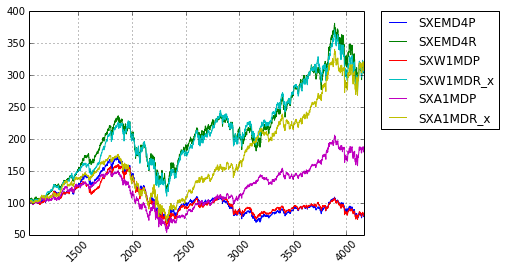

In [5]:
#max div
df_1 = myf.get_web_h(['SXEMD4P', 'SXEMD4R', 'SXEMD4GR'], usedates=True)
df_2 = myf.get_web_h(['SXW1MDP', 'SXW1MDR', 'SXW1MDR'], usedates=True) #gloabl
df_3 = myf.get_web_h(['SXA1MDP', 'SXA1MDR', 'SXA1MDR'], usedates=True)

dft = pd.merge(df_1, df_2, how='left', on='Date')
dft = pd.merge(dft, df_3, how='left', on='Date')

stats = myf.calc_stats_sharpe_ext(df_1, rfrate=True)
df_1.head()
dft = dft[-dft.SXA1MDP.isnull()]
dft.iloc[:,1:] = (dft.iloc[:,1:]/dft.iloc[0,1:])*100
dft[[1,2,4,5,7,8]].plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)

In [4]:
stats

SXEMD4P     SXEMD4R    SXEMD4GR            period
return actual         0      -0.2625      3.3023         NaN  as of 2000-03-20
                      1   -0.2339254    0.305666   0.4868848                5y
                      2    -0.125252   0.1714908   0.2589838                3y
                      3    -0.226128  -0.1494573  -0.1311312                1y
                      4   -0.1174007 -0.08198016 -0.07221803               YTD
                      5  0.005590401  0.01778997  0.02289086                1m
return ann.           0  -0.01811928   0.0915799         NaN  as of 2000-03-20
                      1  -0.05059931   0.0533448  0.08036184                5y
                      2  -0.04251755  0.05273199  0.07764092                3y
                      3   -0.2199521  -0.1451772  -0.1273359                1y
                      4    -0.298675  -0.2157291  -0.1918037               YTD
                      5   0.06540006    0.221869   0.2932919                1m
volatility ann.       0    0.1912631   0.1907876   0.1953671  as of 2000-03-20
                      1    0.1813708   0.1811266   0.1811688                5y
                      2    0.1705602   0.1707464    0.170996                3y
                      3    0.2280471   0.2284357   0.2287614                1y
                      4    0.2531837   0.2533902   0.2537219               YTD
                      5    0.2001887   0.2008185   0.2013218                1m
dividend yield ann.   0          NaN   0.1096992         NaN  as of 2000-03-20
                      1          NaN   0.1039441   0.1309611                5y
                      2          NaN  0.09524954   0.1201585                3y
                      3          NaN   0.0747749  0.09261625                1y
                      4          NaN  0.08294594   0.1068713               YTD
                      5          NaN   0.1564689   0.2278918                1m
Sharpe ratio EUR ann. 0  -0.09939696   0.4550972         NaN  as of 2000-03-20
                      1   -0.2022858   0.3709208    0.510745                5y
                      2   -0.1719243   0.3840854   0.5206985                3y
                      3   -0.9481145   -0.555136  -0.4650446                1y
                      4    -1.000803  -0.5568861  -0.4364958               YTD
                      5     1.574703    2.195736    2.450243                1m
max drawdown          0    0.6032471   0.5054719           0  as of 2000-03-20
                      1    0.3233496   0.2732597   0.2624808                5y
                      2    0.3223767   0.2732597   0.2624808                3y
                      3    0.2930912   0.2562207   0.2500492                1y
                      4    0.1509687   0.1458505   0.1449823               YTD
                      5   0.06122709  0.05371165  0.05096033                1m

,Date,SD3E,SD3T,SD3GT,SD2F,SD2G_x,SD2G_y,SD4AP,SD4AR_x,SD4AR_y
0,1998-12-30,100,100,NaN,100,100,100,NaN,NaN,NaN
1,1999-01-04,102.855,102.868,NaN,102.183,102.183,102.183,NaN,NaN,NaN
2,1999-01-05,104.484,104.497,NaN,103.233,103.233,103.233,NaN,NaN,NaN
3,1999-01-06,106.083,106.096,NaN,105.049,105.049,105.049,NaN,NaN,NaN
4,1999-01-07,105.152,105.166,NaN,105.557,105.557,105.557,NaN,NaN,NaN


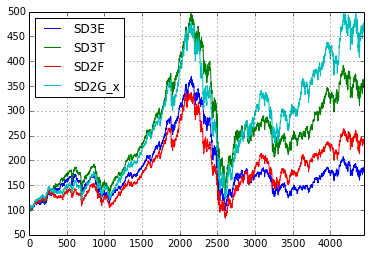

In [7]:
df_1 = myf.get_web_h(['SD3E', 'SD3T', 'SD3GT'], usedates=True) #euro
df_2 = myf.get_web_h(['SD2F', 'SD2G', 'SD2G'], usedates=True) #nordic
df_3 = myf.get_web_h(['SD4AP', 'SD4AR', 'SD4AR'], usedates=True) #america

dft = pd.merge(df_1, df_2, how='left', on='Date')
dft = pd.merge(dft, df_3, how='left', on='Date')

stats = myf.calc_stats_sharpe_ext(df_1, rfrate=True)
df_1.head()
#dft = dft[-dft.SXA1MDP.isnull()]
dft.iloc[:,1:] = (dft.iloc[:,1:]/dft.iloc[0,1:])*100
dft[[0,1,2,4,5]].plot()
dft.head()

In [8]:
myf.calc_stats_sharpe_ext(df_1, rfrate=True)

SD3E        SD3T       SD3GT            period
return actual         0     0.75609     2.47001         NaN  as of 1998-12-30
                      1 -0.01616301    0.217573   0.3081955                5y
                      2   0.1840033   0.3197517   0.3704142                3y
                      3 -0.08214295 -0.04709846 -0.03396979                1y
                      4 -0.04997133 -0.02964198 -0.02163008               YTD
                      5  0.01481109  0.02646011  0.03077498                1m
return ann.           0  0.03217667  0.07248149         NaN  as of 1998-12-30
                      1 -0.00317015  0.03910444  0.05374213                5y
                      2  0.05636956  0.09426084   0.1077262                3y
                      3 -0.07970024 -0.04567192 -0.03293401                1y
                      4  -0.1355258 -0.08193167 -0.06023311               YTD
                      5   0.1818413    0.345511   0.4112027                1m
volatility ann.       0   0.2017578   0.2017459   0.2256242  as of 1998-12-30
                      1   0.1932831    0.193144   0.1931819                5y
                      2   0.1729136   0.1726604   0.1726308                3y
                      3   0.2178818    0.217455   0.2173566                1y
                      4   0.2272948   0.2266536   0.2265092               YTD
                      5   0.1632668   0.1619674   0.1617827                1m
dividend yield ann.   0         NaN  0.04030482         NaN  as of 1998-12-30
                      1         NaN  0.04227459  0.05691228                5y
                      2         NaN  0.03789127  0.05135661                3y
                      3         NaN  0.03402831  0.04676623                1y
                      4         NaN  0.05359415  0.07529272               YTD
                      5         NaN   0.1636697   0.2293614                1m
Sharpe ratio EUR ann. 0   0.1558479   0.3458027         NaN  as of 1998-12-30
                      1  0.08432592   0.2988031   0.3710202                5y
                      2   0.4034988   0.6081397   0.6791347                3y
                      3  -0.2557646 -0.09858123 -0.04089932                1y
                      4  -0.1630668   0.1088362   0.2149955               YTD
                      5    2.044373    2.790541    3.061652                1m
max drawdown          0   0.7329549   0.7175441           0  as of 1998-12-30
                      1   0.3013064   0.2739738   0.2700751                5y
                      2   0.2286523   0.2079519    0.200781                3y
                      3   0.1886656   0.1839112   0.1823251                1y
                      4   0.1143296   0.1138745   0.1137795               YTD
                      5  0.05486456  0.04592572  0.04348782                1m

In [9]:
myf.calc_stats_sharpe_ext(df_2, rfrate=True)

SD2F      SD2G_x      SD2G_y            period
return actual         0      1.32519     3.57832     3.57832  as of 1998-12-30
                      1    0.1801377   0.4169934   0.4169934                5y
                      2    0.1654445    0.296912    0.296912                3y
                      3  -0.07424911 -0.03500141 -0.03500141                1y
                      4  -0.08123582 -0.05326217 -0.05326217               YTD
                      5 -0.001254236  0.01264501  0.01264501                1m
return ann.           0   0.04860207  0.08933153  0.08933153  as of 1998-12-30
                      1   0.03280065  0.07027382  0.07027382                5y
                      2   0.05096483  0.08807608  0.08807608                3y
                      3  -0.07203183 -0.03393473 -0.03393473                1y
                      4   -0.2139212  -0.1440058  -0.1440058               YTD
                      5  -0.01416042   0.1534903   0.1534903                1m
volatility ann.       0    0.2097683   0.2094413   0.2094413  as of 1998-12-30
                      1     0.193374   0.1929725   0.1929725                5y
                      2    0.1743217   0.1742201   0.1742201                3y
                      3    0.2246808   0.2247019   0.2247019                1y
                      4     0.247667   0.2476342   0.2476342               YTD
                      5    0.1558906   0.1548063   0.1548063                1m
dividend yield ann.   0          NaN  0.04072946  0.04072946  as of 1998-12-30
                      1          NaN  0.03747317  0.03747317                5y
                      2          NaN  0.03711125  0.03711125                3y
                      3          NaN   0.0380971   0.0380971                1y
                      4          NaN  0.06991545  0.06991545               YTD
                      5          NaN   0.1676507   0.1676507                1m
Sharpe ratio EUR ann. 0    0.2349568   0.4170219   0.4170219  as of 1998-12-30
                      1    0.2494752   0.4343833   0.4343833                5y
                      2    0.3739797   0.5694406   0.5694406                3y
                      3   -0.1987202 -0.02459448 -0.02459448                1y
                      4    -0.557586  -0.2069674  -0.2069674               YTD
                      5     1.258888    2.279502    2.279502                1m
max drawdown          0    0.7532916    0.743799    0.743799  as of 1998-12-30
                      1    0.2870705   0.2814341   0.2814341                5y
                      2    0.1908444   0.1818081   0.1818081                3y
                      3    0.1818074   0.1818081   0.1818081                1y
                      4    0.1353722   0.1353727   0.1353727               YTD
                      5   0.04110736  0.03993088  0.03993088                1m

(array([ 731216.,  731947.,  732677.,  733408.,  734138.,  734869.,  735599.]),
 <a list of 7 Text xticklabel objects>)

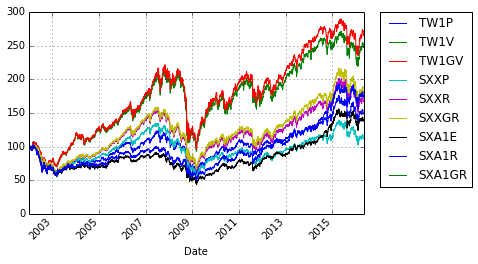

In [22]:
df_1 = myf.get_web_h(['TW1P', 'TW1V', 'TW1GV'], usedates=True) #global
df_2 = myf.get_web_h(['SXXP', 'SXXR', 'SXXGR'], usedates=True) #europe600
df_3 = myf.get_web_h(['SXA1E', 'SXA1R', 'SXA1GR'], usedates=True) #america600

dft = pd.merge(df_1, df_2, how='left', on='Date')
dft = pd.merge(dft, df_3, how='left', on='Date')
dft.index= dft.Date
dft.iloc[:,1:] = (dft.iloc[:,1:]/dft.iloc[0,1:])*100
dft.plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)

(array([ 731216.,  731947.,  732677.,  733408.,  734138.,  734869.,  735599.]),
 <a list of 7 Text xticklabel objects>)

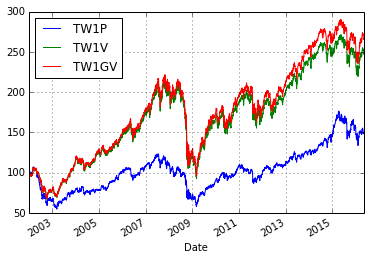

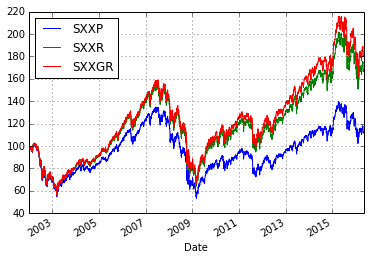

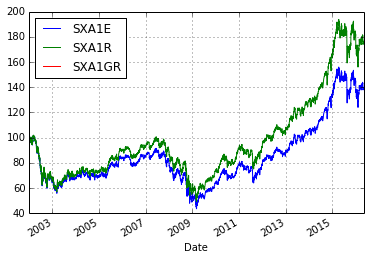

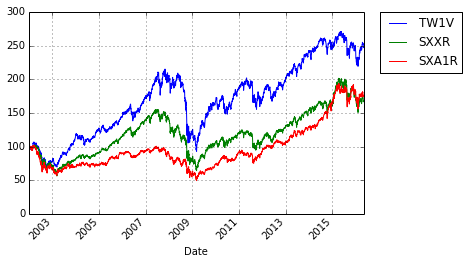

In [23]:
#dft = dft[dft.index>'2008-01-01']
dft.iloc[:,1:] = (dft.iloc[:,1:]/dft.iloc[0,1:])*100
dft.index= dft.Date
dft[[1,2,3]].plot()
dft[[4,5,6]].plot()
dft[[7,8,9]].plot()
dft[[2,5,8]].plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)

In [9]:
dft.head()

,Date,TW1P,TW1V,TW1GV,SXXP,SXXR,SXXGR,SXA1E,SXA1R,SXA1GR
0,2001-12-27,100,100,100,100,100,100,100,100,NaN
1,2001-12-28,100.6428,100.7012,100.6933,100.5453,100.5429,100.5428,100.08,100.0842,NaN
2,2002-01-02,98.88292,101.137,101.1886,98.84891,98.8601,98.86726,97.48031,97.49702,NaN
3,2002-01-03,101.0749,102.9183,102.9715,100.6664,100.6793,100.6844,98.89014,98.90764,NaN
4,2002-01-04,102.0655,103.3921,103.4469,101.1646,101.1811,101.1799,99.9875,100.0062,NaN


(array([ 733408.,  733773.,  734138.,  734503.,  734869.,  735234.,
         735599.,  735964.]), <a list of 8 Text xticklabel objects>)

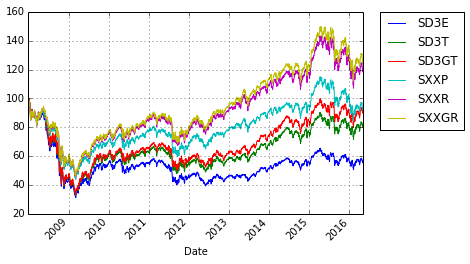

In [27]:
df_1 = myf.get_web_h(['SD3E', 'SD3T', 'SD3GT'], usedates=True) #euro
df_2 = myf.get_web_h(['SXXP', 'SXXR', 'SXXGR'], usedates=True) #europe600

dft = pd.merge(df_1, df_2, how='left', on='Date')
dft.index= dft.Date
dft = dft[dft.index>'2008-01-01']

dft.iloc[:,1:] = (dft.iloc[:,1:]/dft.iloc[0,1:])*100
dft.plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)

In [29]:
dft[[0,1]]

,Date,SD3E
Date,,
2008-01-02,2008-01-02,100
2008-01-03,2008-01-03,99.62024
2008-01-04,2008-01-04,98.79699
2008-01-07,2008-01-07,99.20735
2008-01-08,2008-01-08,99.76627
2008-01-09,2008-01-09,99.13386
2008-01-10,2008-01-10,97.55361
2008-01-11,2008-01-11,97.07954
2008-01-14,2008-01-14,97.29118


,Date,sx5e,sx5p,sxxp,sxxe
5427,2008-01-02,100,100,100,100
5428,2008-01-03,99.86611,100.1764,99.68618,99.57798
5429,2008-01-04,98.41677,98.46865,97.75605,97.97282
5430,2008-01-07,98.71267,98.86979,97.55332,97.79475
5431,2008-01-08,98.986,99.44342,98.15319,98.17774


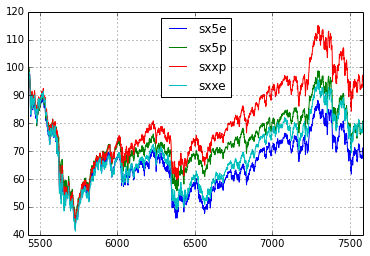

In [3]:
x = myf.get_web_h(['sx5e', 'sx5p', 'sxxp', 'sxxe'])
x = x[x.Date>'2008-01-01']
x.iloc[:,1:] = x.iloc[:,1:] / x.iloc[0,1:] * 100
x.plot()
x.head()

Populating the interactive namespace from numpy and matplotlib


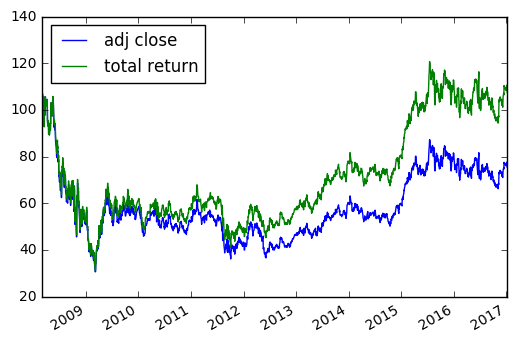

In [2]:
import pandas as pd
import qadconnect34plus as q
import datetime as dt
import myfunctions as myf

%pylab inline

startdate = '2008-03-02'
enddate = str(dt.date.today())

identifier = 'DE0005810055'

x = q.get_timeseries(identifier, 'adj close', startdate, enddate, 'EUR')
y = q.get_timeseries(identifier, 'total return', startdate, enddate, 'EUR')
z = pd.concat([x,y], axis=1)
z.index.name = None
z.columns = ['adj close','total return']
z = z.fillna(method='pad')
z = z / z.iloc[0,] * z.iloc[0,0]
z.plot()
z.tail()
z['Date'] = z.index
#myf.calc_stats_sharpe_ext(z[[2,0,1,1]], rfrate=True)

,adj close,total return,Date
2017-01-02,76.979996,109.675077,2017-01-02
2017-01-03,77.610001,110.572669,2017-01-03
2017-01-04,77.100007,109.846070,2017-01-04
2017-01-05,76.390000,108.834520,2017-01-05
2017-01-06,75.440003,107.481021,2017-01-06


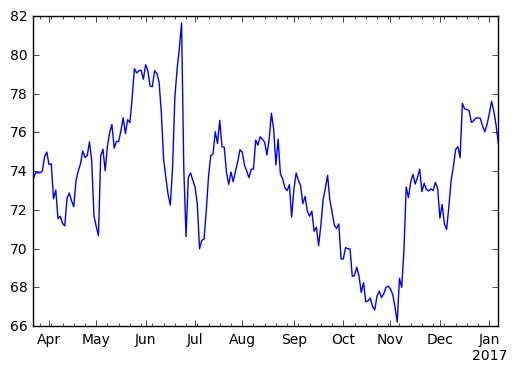

In [5]:
#z.iloc[2000:,:].plot()
z.iloc[2100:,0].plot()
z.tail()

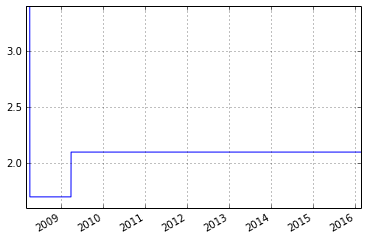

In [15]:
g = q.get_dps_ts(identifier, startdate, enddate, all_=False)
g.iloc[:,1].plot() #div
#g.head()

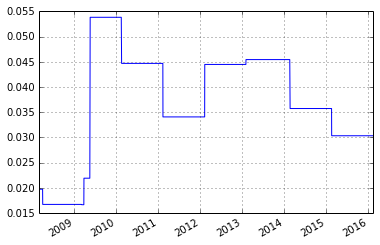

In [9]:
q.get_dps_ts(identifier, startdate, enddate, all_=False).iloc[:,0].plot() #yield

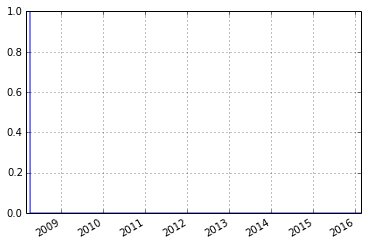

In [16]:
q.get_dps_ts(identifier, startdate, enddate, all_=False).iloc[:,2].plot()

In [17]:
import qadconnect34plus as q
q.get_infocode('GB00B1VYCH82')

22391